# Importing Required Libraries

In [0]:
!pip install --upgrade jupyterhub


In [0]:
# !pip install Opencv-python
# !pip install seaborn
# !pip install sklearn
# !pip install nltk
# !pip install wordcloud
# !pip install prettytable

In [0]:
import os
import re
import cv2
import sys
import nltk
import shutil
import string
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from prettytable import from_html_one
from PIL import Image
from tqdm import tqdm
from zipfile import ZipFile
from prettytable import PrettyTable
from bs4 import BeautifulSoup
from scipy.sparse import hstack
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk import Counter # Used to count number of times a word repeated
# from sqlalchemy import create_engine
from sklearn.model_selection import GridSearchCV, train_test_split

from sklearn import metrics
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.multiclass import OneVsRestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, hamming_loss, precision_score, recall_score,f1_score



In [0]:
from google.colab import drive
drive.mount('gdrive',force_remount=True)

# Business Problem
## Discription

Social tagging of movies reveals a wide range of heterogeneous information about movies, like the genre, plot structure, soundtracks, metadata, visual and emotional experiences. Such information can be valuable in building automatic systems to create tags for movies. Automatic tagging systems can help recommendation engines to improve the retrieval of similar movies as well as help viewers to know what to expect from a movie in advance. In this paper, we set out to the task of collecting a corpus of movie plot synopses and tags. We describe a methodology that enabled us to build a fine-grained set of around 70 tags exposing heterogeneous characteristics of movie plots and the multi-label associations of these tags with some 14K movie plot synopses. We investigate how these tags correlate with movies and the flow of emotions throughout different types of movies. Finally, we use this corpus to explore the feasibility of inferring tags from plot synopses. We expect the corpus will be useful in other tasks where analysis of narratives is relevant.

## Problem Statemtent
Suggest the tags based on the synopses and title the movie.

## Source

<strong>Kaggle :</strong>https://www.kaggle.com/cryptexcode/mpst-movie-plot-synopses-with-tags


## Real World Objectives:

<ol>
<li>Predicting as many tags as possible for a movie </li>
<li>Predicting wrong tags may lead to bad coustomer experience</li>
<li>No time restrictions</li>
</ol>

# Machine Lerning Problem
## Data

In [0]:
# Reading Data

data = pd.read_csv('mpst_full_data.csv')
# data.to_csv('mpst_full_data.csv')
data.to_csv('data.csv', index = False)


In [0]:
data.head()

,imdb_id,title,plot_synopsis,tags,split,synopsis_source
0,tt0057603,I tre volti della paura,Note: this synopsis is for the orginal Italian...,"cult, horror, gothic, murder, atmospheric",train,imdb
1,tt1733125,Dungeons & Dragons: The Book of Vile Darkness,"Two thousand years ago, Nhagruul the Foul, a s...",violence,train,imdb
2,tt0033045,The Shop Around the Corner,"Matuschek's, a gift store in Budapest, is the ...",romantic,test,imdb
3,tt0113862,Mr. Holland's Opus,"Glenn Holland, not a morning person by anyone'...","inspiring, romantic, stupid, feel-good",train,imdb
4,tt0086250,Scarface,"In May 1980, a Cuban man named Tony Montana (A...","cruelty, murder, dramatic, cult, violence, atm...",val,imdb


<strong>Column Discription</strong>

<ol>
<li><strong>imdb_id:- </strong>    IMDB Movie Id</li>
<li><strong>title:- </strong>    Name of the Movie</li>
<li><strong>plot_synopsis:- </strong>    Summary of the movie</li>
<li><strong>tags:-</strong>     Tags of the movie</li>
<li><strong>split:-</strong>     Represents train, test or validation data</li>
<li><strong>synopsis_source:-</strong>     From where summary of the movie is collected from</li>

</ol>


## Type of Machine Learning Problem

<p>This is a kind of multilabel classification problem, <strong>multilabel </strong>means each data point will have a bunch of labels, unlike each data point, having one label, for example, each movie will have many tags like violence, cult, gothic, cruelty,  sadist, feel-good, revenge, inspiring, romantic, stupid.</p>

## Performance Metric

<b>Micro-Averaged F1-Score (Mean F Score) </b>: 
The F1 score can be interpreted as a weighted average of the precision and recall, where an F1 score reaches its best value at 1 and worst score at 0. The relative contribution of precision and recall to the F1 score are equal. The formula for the F1 score is:

<i>F1 = 2 * (precision * recall) / (precision + recall)</i><br>

In the multi-class and multi-label case, this is the weighted average of the F1 score of each class. <br>

<b>'Micro f1 score': </b><br>
Calculate metrics globally by counting the total true positives, false negatives and false positives. This is a better metric when we have class imbalance.
<br>

<b>'Macro f1 score': </b><br>
Calculate metrics for each label, and find their unweighted mean. This does not take label imbalance into account.
<br>

https://sebastianraschka.com/faq/docs/multiclass-metric.html

http://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html <br>
<br>
<b> Hamming loss </b>: The Hamming loss is the fraction of labels that are incorrectly predicted. <br>
https://en.wikipedia.org/wiki/Multi-label_classification#Statistics_and_evaluation_metrics

# Exploratory Data Analysis

## Loading Data

In [0]:
data = pd.read_csv('data.csv')

In [0]:
data.head()

,imdb_id,title,plot_synopsis,tags,split,synopsis_source
0,tt0057603,I tre volti della paura,Note: this synopsis is for the orginal Italian...,"cult, horror, gothic, murder, atmospheric",train,imdb
1,tt1733125,Dungeons & Dragons: The Book of Vile Darkness,"Two thousand years ago, Nhagruul the Foul, a s...",violence,train,imdb
2,tt0033045,The Shop Around the Corner,"Matuschek's, a gift store in Budapest, is the ...",romantic,test,imdb
3,tt0113862,Mr. Holland's Opus,"Glenn Holland, not a morning person by anyone'...","inspiring, romantic, stupid, feel-good",train,imdb
4,tt0086250,Scarface,"In May 1980, a Cuban man named Tony Montana (A...","cruelty, murder, dramatic, cult, violence, atm...",val,imdb


<strong>Checking number of duplicates in each data set</strong>

In [0]:
print(pd.DataFrame(data.duplicated().values, columns=['d']).d.value_counts())

False    14828
Name: d, dtype: int64


<strong>Data sets do not have duplicate rows</strong>

In [0]:
train_size,test_size,val_size  = data.split.value_counts()
print('Total number of data points in train data :', train_size)
print('Total number of data points in test data :', test_size)
print('Total number of data points in validation data :', val_size)


Total number of data points in train data : 9489
Total number of data points in test data : 2966
Total number of data points in validation data : 2373


## Tag Analysis

In [0]:
print(data.tags[0])
print(data.tags[3])
print(data.tags[10])

cult, horror, gothic, murder, atmospheric
inspiring, romantic, stupid, feel-good
revenge, neo noir, murder, violence, flashback


<ol>
<li>Each tag is separated by cama (',')</li>
<li>Get tokenized tags</li>
<li>Some of the tags are with '-', ' ' which must be replaced by '_'</li>
<li>Count  frequency of each tag</li>
</ol>

100%|██████████| 14828/14828 [00:00<00:00, 104666.13it/s]


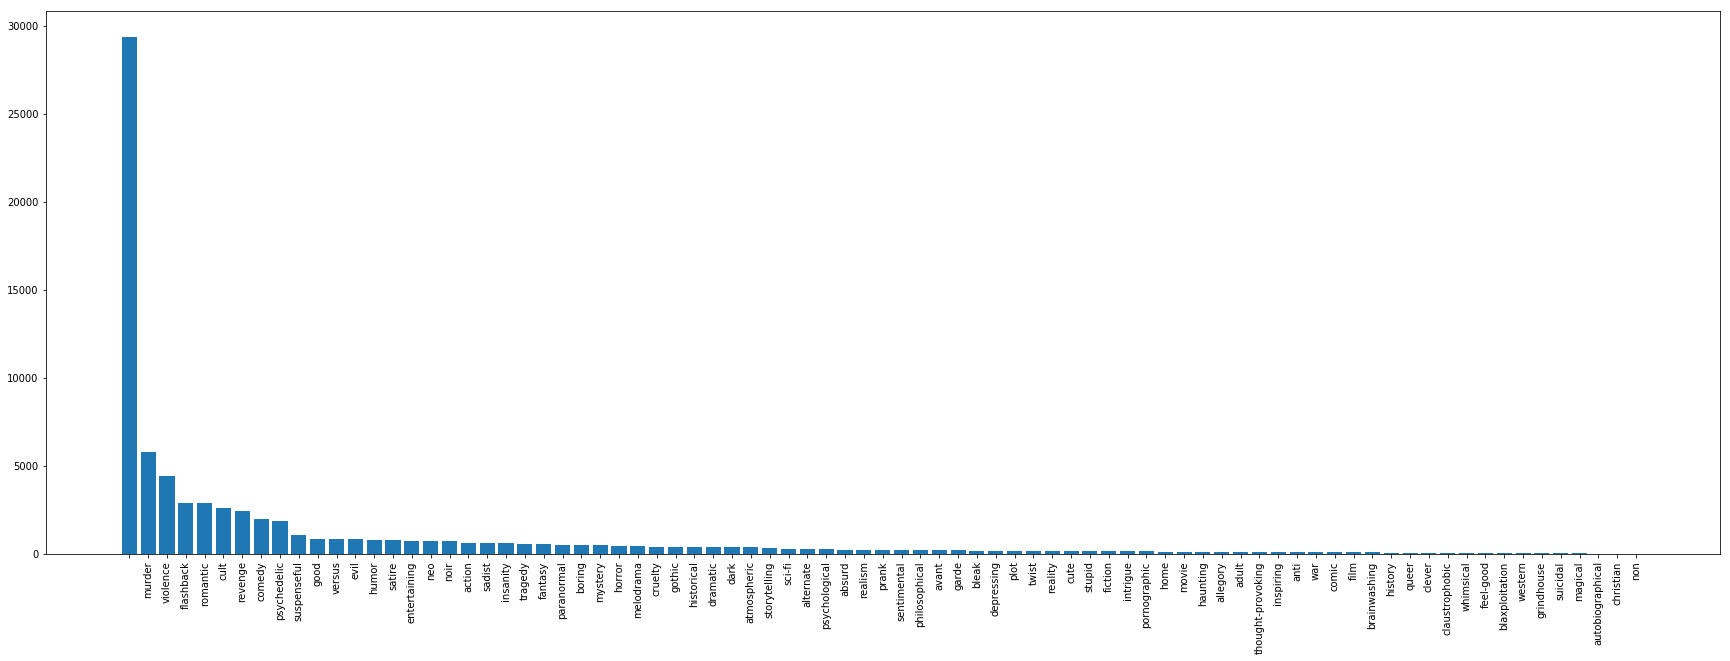

<Figure size 432x288 with 0 Axes>

In [0]:
#Taking frequency of each tag


tag_count = Counter()

for i in tqdm(data.tags):
      for j in i.split():
            # Updating count of each tag in every itteration
            tag_count.update(j.split(',')) 

# Sorting based on number of times  tag occured
tag_count = dict(sorted(tag_count.items(), key = lambda x:x[1], reverse=True))    


# Plotting tag count
tag_count = dict(tag_count)
plt.figure(figsize=(30,10))
plt.bar((tag_count.keys()), tag_count.values())
plt.xticks(rotation = 90)
plt.show()
plt.savefig('tag_count.png')


<strong>There is a tag called "sci-fi", if we clean the data this tag may be divided into two tags so we shall replace this sci-fi into science_fiction

<strong>And tag for first histogram is missing, something went wrong? Lets try to print these tags and their frequencies</li>




('absurd', 'absurd')
('action', 'action')
('adult comedy', 'adult')
('allegory', 'allegory')
('alternate history', 'alternate')
('alternate reality', 'anti')
('anti war', 'atmospheric')
('atmospheric', 'autobiographical')
('autobiographical', 'avant')
('avant garde', 'blaxploitation')
('blaxploitation', 'bleak')
('bleak', 'boring')
('boring', 'brainwashing')
('brainwashing', 'christian')
('christian film', 'claustrophobic')

In [0]:
tag_count

<strong>So, thats the problem, even space is consedered as a tag, so we must clean the data, we shall use reguler expression library to clean the data</strong>

100%|██████████| 14828/14828 [00:00<00:00, 282988.08it/s]


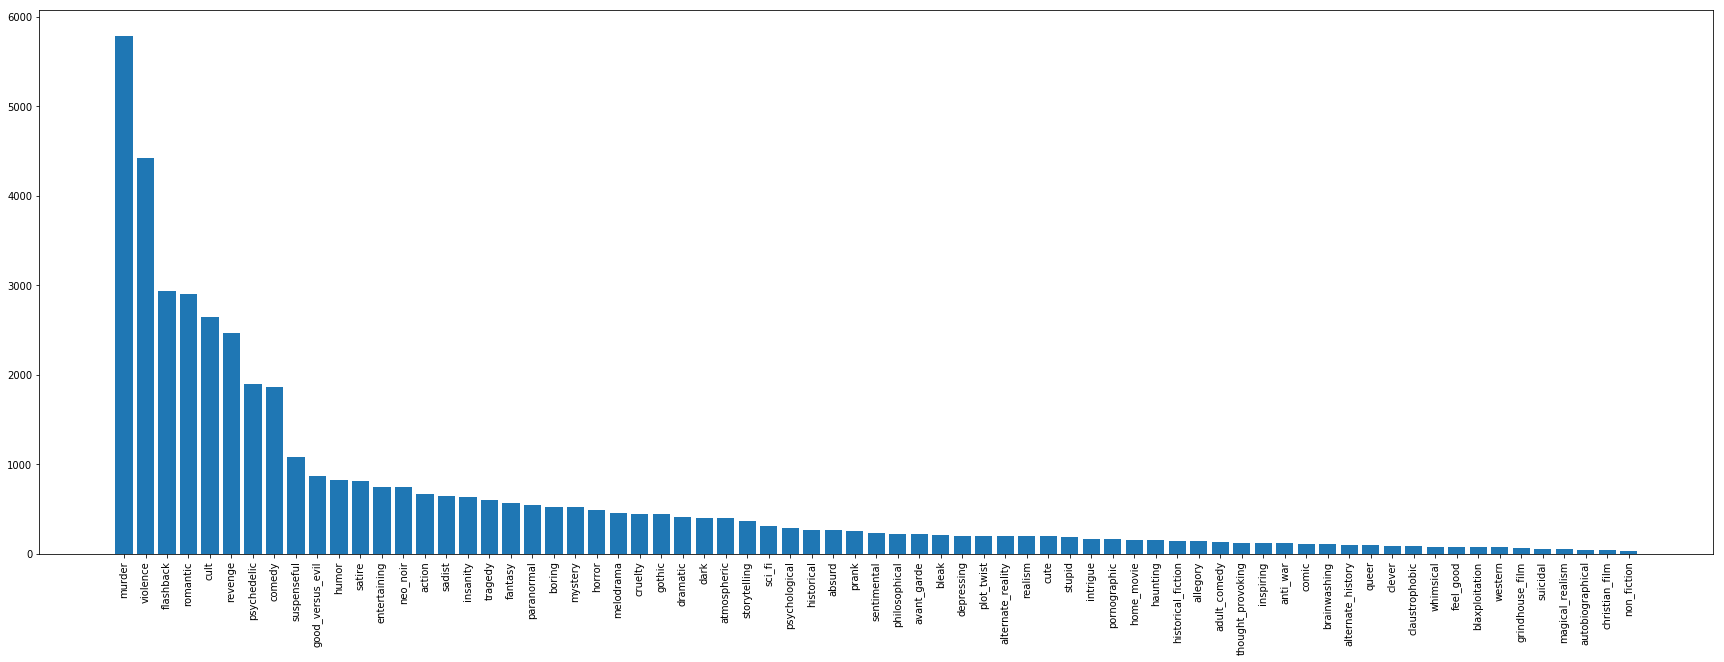

<Figure size 432x288 with 0 Axes>

In [0]:
cl_tag = []
for i in data.tags:
    #Substuting (, ) as (,)
    cl_tg = re.sub('-','_', i)

    cl_tg = re.sub(', ',',',cl_tg)
    cl_tg = re.sub(' ','_',cl_tg)
    cl_tag.append(cl_tg)


tag_count = Counter()
for i in tqdm(cl_tag):
  for j in i.split():
    tag_count.update(j.split(','))

tag_count = dict(sorted(tag_count.items(), key = lambda x:x[1], reverse=True))    
  
tag_count = dict(tag_count)
plt.figure(figsize=(30,10))
plt.bar((tag_count.keys()), tag_count.values())
plt.xticks(rotation = 90)
plt.show()
plt.savefig('cl_tag_count.png')

In [0]:
# with open('tag_count.pkl','wb') as f:
#   pickle.dump(tag_count,f)

In [0]:
with open('tag_count.pkl', 'rb') as f:
  tag_count = pickle.load(f)


In [0]:
#Putting this cleaned taggs into data frame
data['clean_tag'] = cl_tag
data.to_csv('data.csv', index=False)

### Observations:
<ol>
<li>Most of the tags appear less than 1000 times</li>
<li>Only eight of the tags are appeared more than 1000 times</li>
<li>Murder is the tag that appeared max number of times i.e almost 6000 times</li>
</ol>

In [0]:
print('Total number of unique tags:', len(tag_count))

Total number of unique tags: 71


## Tags Per Each Movie

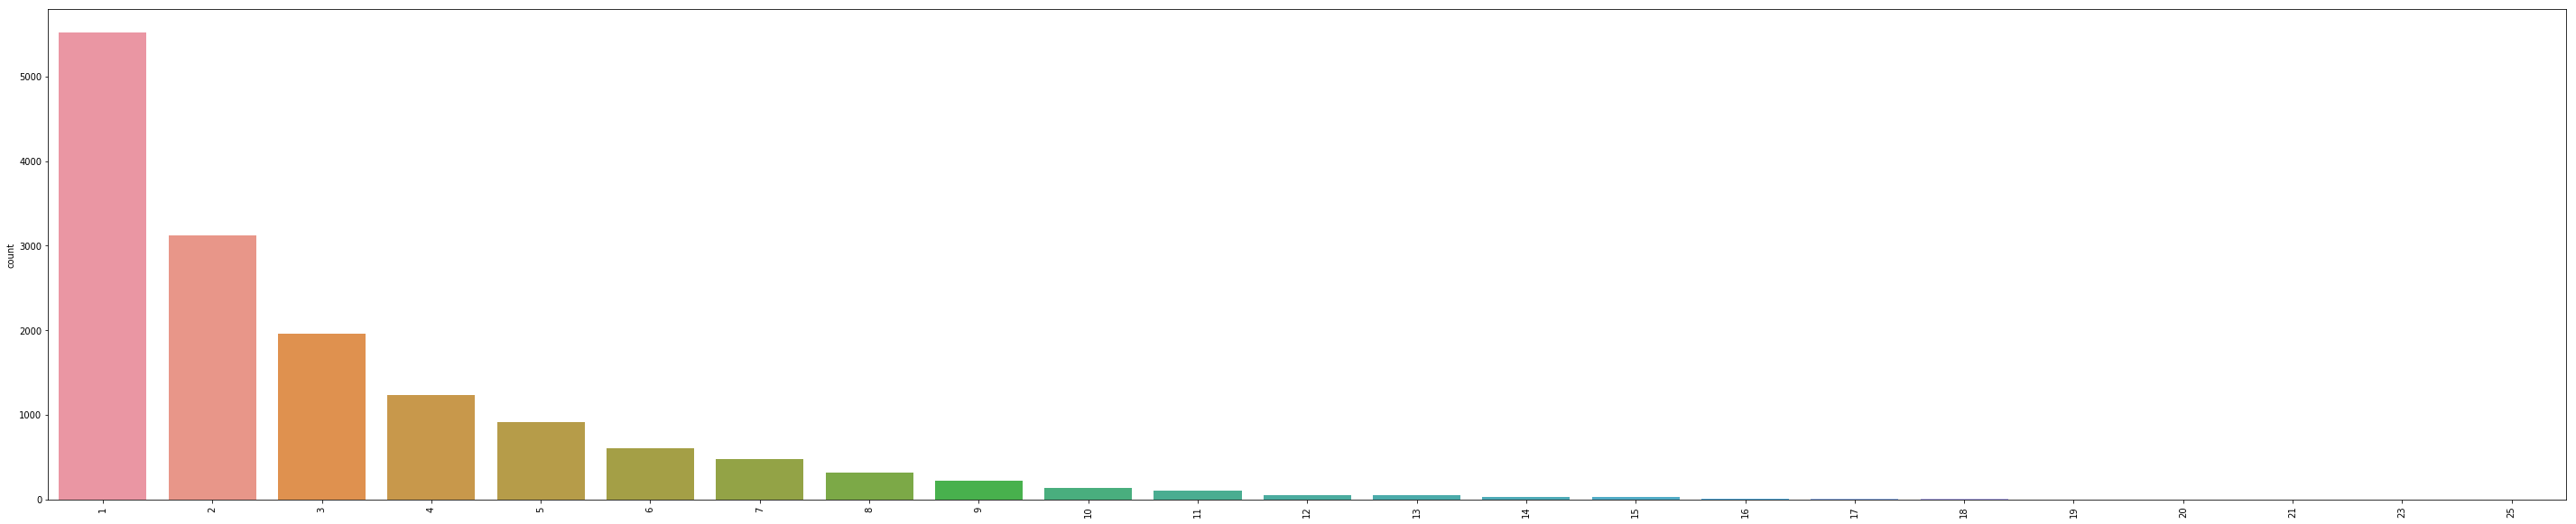

<Figure size 432x288 with 0 Axes>

In [0]:
no_tags = []

for i in data.clean_tag:
      
      no_tags.append(len(i.split(',')))

plt.figure(figsize=(50,10))
sns.countplot(no_tags)
plt.xticks(rotation = 90)
plt.show()
plt.savefig('no_tags.png')      

In [0]:
# with open('no_tags.pkl','wb') as f:
#   pickle.dump(no_tags,f)

In [0]:
with open('no_tags.pkl','rb') as f:
  no_tags = pickle.load(f)

## Observations:
<ol>
<li>Most of the movies have 1 or 2 number of tags</li>
<li>Almost above 5000 movies have only one tag</li>
<li>Maximum number of tags is 25</li>
<li>Minimum number of tags is 1</li>

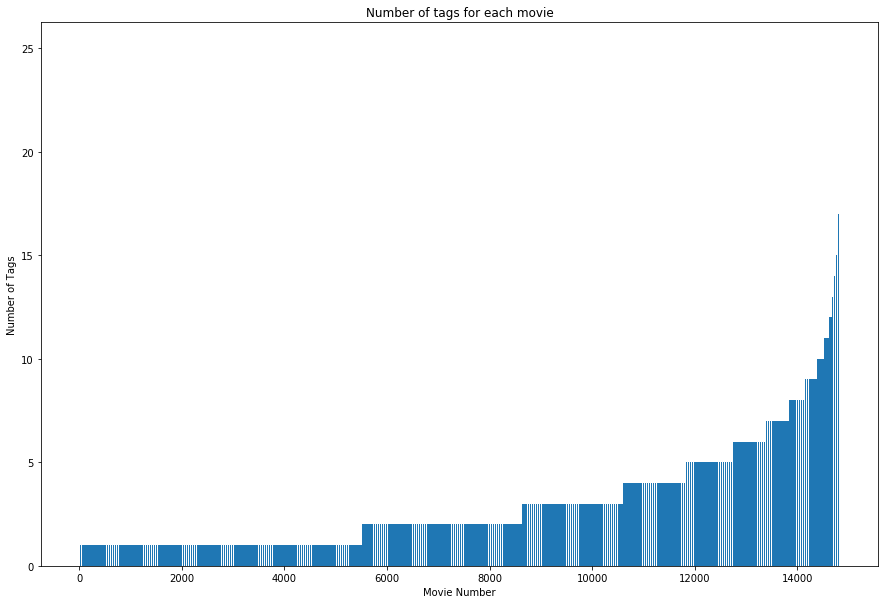

In [0]:
plt.figure(figsize=(15,10))
plt.title('Number of tags for each movie')
plt.xlabel('Movie Number')
plt.ylabel('Number of Tags')
plt.bar(np.array([i for i in range(len(no_tags))]),sorted(no_tags))
plt.show()

##  Observations:

<ol>
<li>Almost 5500 movies have only one tag</li>
<li>Nearly 3500 movies have two tags</li>

In [0]:
print('Maximum number of tags is',max(no_tags))
print('Mainimum number of tags is',min(no_tags))
print('Average number of tags is ', sum(no_tags)/len(no_tags))


Maximum number of tags is 25
Mainimum number of tags is 1
Average number of tags is  2.9812516859994607


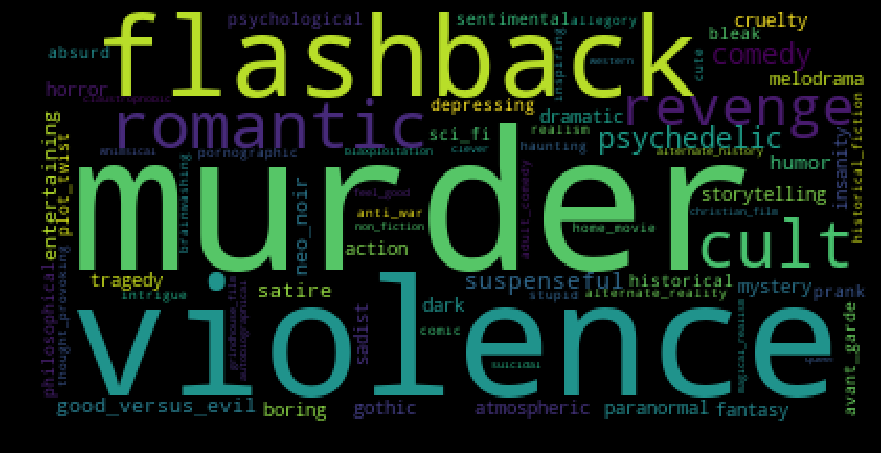

<Figure size 432x288 with 0 Axes>

In [0]:
plt.figure(figsize=(15,10), facecolor='k')

plt.imshow(WordCloud(contour_color='firebrick').generate_from_frequencies(tag_count))
plt.show()
plt.savefig('word_cloud.png')

## Observations

<ol>
<li>Tag that is with most frequency is murder and violence</li>
<li>Next important tags are flashback, romantic, revenge, cult and comedy</li>
</li>

In [0]:
# sum(no_tags)/len(no_tags)
data['no_tags'] = no_tags
# Saving data frame
data.to_csv('data.csv', index=False)
data.head()

,imdb_id,title,plot_synopsis,tags,split,synopsis_source,clean_tag,no_tags
0,tt0057603,I tre volti della paura,Note: this synopsis is for the orginal Italian...,"cult, horror, gothic, murder, atmospheric",train,imdb,"cult,horror,gothic,murder,atmospheric",5
1,tt1733125,Dungeons & Dragons: The Book of Vile Darkness,"Two thousand years ago, Nhagruul the Foul, a s...",violence,train,imdb,violence,1
2,tt0033045,The Shop Around the Corner,"Matuschek's, a gift store in Budapest, is the ...",romantic,test,imdb,romantic,1
3,tt0113862,Mr. Holland's Opus,"Glenn Holland, not a morning person by anyone'...","inspiring, romantic, stupid, feel-good",train,imdb,"inspiring,romantic,stupid,feel_good",4
4,tt0086250,Scarface,"In May 1980, a Cuban man named Tony Montana (A...","cruelty, murder, dramatic, cult, violence, atm...",val,imdb,"cruelty,murder,dramatic,cult,violence,atmosphe...",10


## Top 10 Tags

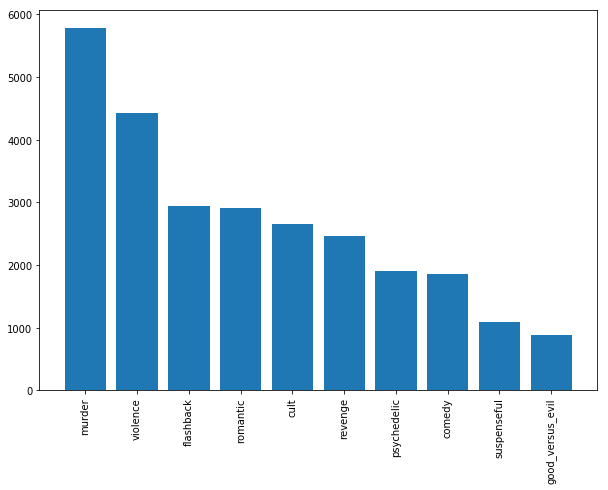

<Figure size 432x288 with 0 Axes>

In [0]:
plt.figure(figsize=(10,7))
plt.bar(list(tag_count.keys())[:10], list(tag_count.values())[:10])
plt.xticks(rotation = 90)
plt.show()
plt.savefig('top_10_tag.png')

## Cleaning & Preprocessing Data


### Finding Out Special Charecters Present In Our Data

In [0]:
t =[i for i in string.ascii_lowercase]
t.extend([i for i in string.ascii_uppercase])

chars = []
for i in data.plot_synopsis:
  for j in i:
    if j not in t:
        chars.append(j)
        temp = j


special_chars = list(set(chars))    

In [0]:
special_chars

<strong>We found chainese characters in the special charecters, so we shall try to replace those chinese characters with english meaning</strong>

In [0]:
!pip install googletrans

In [0]:
from googletrans import Translator

In [0]:
# https://pypi.org/project/googletrans/

trans = Translator() # Google Translator

special_chars_meaning = {}
for i in tqdm(special_chars, position=0):
  
    special_chars_meaning[i] = trans.translate(i).text
    # print(trans.translate(i).text)
  


100%|██████████| 605/605 [00:39<00:00, 14.71it/s]


In [0]:
special_chars_meaning

In [0]:
nltk.download('stopwords')

stopwords = stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [0]:
','.join(stopwords)

"i,me,my,myself,we,our,ours,ourselves,you,you're,you've,you'll,you'd,your,yours,yourself,yourselves,he,him,his,himself,she,she's,her,hers,herself,it,it's,its,itself,they,them,their,theirs,themselves,what,which,who,whom,this,that,that'll,these,those,am,is,are,was,were,be,been,being,have,has,had,having,do,does,did,doing,a,an,the,and,but,if,or,because,as,until,while,of,at,by,for,with,about,against,between,into,through,during,before,after,above,below,to,from,up,down,in,out,on,off,over,under,again,further,then,once,here,there,when,where,why,how,all,any,both,each,few,more,most,other,some,such,no,nor,not,only,own,same,so,than,too,very,s,t,can,will,just,don,don't,should,should've,now,d,ll,m,o,re,ve,y,ain,aren,aren't,couldn,couldn't,didn,didn't,doesn,doesn't,hadn,hadn't,hasn,hasn't,haven,haven't,isn,isn't,ma,mightn,mightn't,mustn,mustn't,needn,needn't,shan,shan't,shouldn,shouldn't,wasn,wasn't,weren,weren't,won,won't,wouldn,wouldn't"

In [0]:
stemmer = SnowballStemmer('english')


In [0]:
print(data.plot_synopsis.iloc[5])
print('='*50)
print(data.plot_synopsis.iloc[15])
print('='*50)
print(data.plot_synopsis.iloc[70])
print('='*50)
print(data.plot_synopsis.iloc[1620])


George Falconer (Colin Firth) approaches a car accident in the middle of a snow-white scenery. There is a bloodied man there and he kisses him. He wakes up: he was dreaming about the moment when his partner of 16 years, Jim (Mathew Goode), died--though he was not there with him because Jim was visiting his disapproving family on his own. George remembers the phone ringing on that fateful day, when Jim's cousin told him about the fatal accident, and how George was not welcome to attend the funeral, because of the family's homophobia (common for the period and later). George remembers breaking down to Charley (Julianne Moore) that day, his best friend from his life in London, who had also relocated to LA; once briefly sexually attached to George before he was completely honest with himself, she may still feel attracted to him.George showers and dresses. It's November 30, 1962, the eve of the Cuban missile crisis. Though British, he is now a professor of English at UCLA. He is depressed, 

In [0]:
c = data.shape[0]
def clean_data(string_):

      '''This is a function that removes special characters, apply stemming
            and    convert into lower case and return the cleaned string'''
      global c
      sys.stdout.write('Remaining {}'.format(c))

      test_st = BeautifulSoup(string_).get_text()

      # print('Length of str before', len(test_st))

      nn = []
      # sc_in_str = []
      for j in test_st.split():
            
            word = re.sub(r"won't", "will not", j)
            word = re.sub(r"n\'t", " not", word)
            word = re.sub(r"\'ve", " have", word)
            word = re.sub(r"can\'t", "can not", word)
            word = re.sub(r"\'re", " are", word)
            word = re.sub(r"\'s", " is", word)
            word = re.sub(r"\'d", " would", word)
            word = re.sub(r"\'ll", " will", word)
            word = re.sub(r"\'t", " not", word)
           
            word = re.sub(r"\'m", " am", word)

            for i in special_chars:
                if i in word:
                    try:
                        temp =  word
                        word =  word.replace(i,special_chars_meaning[i])
                        word =  word.lower()
                        # sc_in_str.append(i)

                        # print(temp,j)
                        if temp == word:
                          word = word.replace(i,'')
                    except:
                      pass

            if word not in stopwords:
                  nn.append(stemmer.stem(word))
      
      c -=1 
      
      sys.stdout.write('\r')

      return ' '.join(nn)
      

### Cleaning Plot Synopsis (Replacing Chinese Characters with their english meaning)

In [0]:
clean_plot_synopsis = data.plot_synopsis.apply(clean_data)

In [0]:
print(clean_plot_synopsis.iloc[5])
print('='*50)
print(clean_plot_synopsis.iloc[15])
print('='*50)
print(clean_plot_synopsis.iloc[70])
print('='*50)
print(clean_plot_synopsis.iloc[1620])


georg falcon (colin firth) approach car accid middl snowwhit sceneri there bloodi man kiss he wake dream moment partner  year jim (mathew goode) diedthough jim visit disapprov famili georg rememb phone ring fate day jimi cousin told fatal accid georg welcom attend funer familyi homophobia common period later georg rememb break charley (juliann moore) day best friend life london, also reloc la; briefli sexual attach georg complet honest may still feel attract him.georg shower dress iti novemb   eve cuban missil crisi though british, professor english ucla. he depress never recov loss leav work pack gun briefcase.h tell clean ladi alva (paulett lamori) alway wonder  spite forgotten take bread fridg georg hug leav utter confused.on campus georg notic coupl student chainsmok loi (nicol steinwedell) boy one secretari (keri lynn pratt) tell given address nice new student turn boy kenni potter (nichola hoult) talk class speech georg given classroom concern minor fear kenni discuss recreat dru

<strong>Once again checking for special characters since only chinese characters were replaced previously</strong>

In [0]:
c = data.shape[0]
def normal_clean_data(string_):

      '''This is a function that removes special characters, apply stemming
            and    convert into lower case and return the cleaned string'''
      global c
      sys.stdout.write('Remaining {}'.format(c))

      test_st = BeautifulSoup(string_).get_text()

      # print('Length of str before', len(test_st))

      nn = []
      # sc_in_str = []
      for j in test_st.split():
           
            for i in special_char:
                if i in j:
                        j =  j.replace(i,'')
                        j =  j.lower()
                        # sc_in_str.append(i)

                        
            
            nn.append(j)
      
      c -=1 
      
      sys.stdout.write('\r')

      return ' '.join(nn)
      

In [0]:

chars = []
for i in clean_plot_synopsis:
  for j in i:
    if j not in t:
        chars.append(j)
        temp = j


special_char = list(set(chars))    
special_char

<strong>Cleaning Special Characters

In [0]:
clean_plot_synopsis = clean_plot_synopsis.apply(normal_clean_data)

In [0]:

chars = []
for i in clean_plot_synopsis:
  for j in i:
    if j not in t:
        chars.append(j)
        temp = j


special_char = list(set(chars))    
special_char


[' ']

<strong>As we observe above there are no any special characters in the data exept sapce</strong>

In [0]:
data['clean_plot_synopsis'] = clean_plot_synopsis
data.to_csv('data.csv', index=False)
data.head()

,imdb_id,title,plot_synopsis,tags,split,synopsis_source,clean_tag,no_tags,clean_plot_synopsis
0,tt0057603,I tre volti della paura,Note: this synopsis is for the orginal Italian...,"cult, horror, gothic, murder, atmospheric",train,imdb,"cult,horror,gothic,murder,atmospheric",5,note synopsi orgin italian releas segment cert...
1,tt1733125,Dungeons & Dragons: The Book of Vile Darkness,"Two thousand years ago, Nhagruul the Foul, a s...",violence,train,imdb,violence,1,two thousand year ago nhagruul foul sorcer rev...
2,tt0033045,The Shop Around the Corner,"Matuschek's, a gift store in Budapest, is the ...",romantic,test,imdb,romantic,1,matuschekis gift store budapest workplac alfr ...
3,tt0113862,Mr. Holland's Opus,"Glenn Holland, not a morning person by anyone'...","inspiring, romantic, stupid, feel-good",train,imdb,"inspiring,romantic,stupid,feel_good",4,glenn holland morn person anyonei standard wok...
4,tt0086250,Scarface,"In May 1980, a Cuban man named Tony Montana (A...","cruelty, murder, dramatic, cult, violence, atm...",val,imdb,"cruelty,murder,dramatic,cult,violence,atmosphe...",10,in may cuban man name toni montana al pacino c...


### Cleaning Titles

In [0]:
clean_title = data.title.apply(clean_data)
clean_title = clean_title.apply(normal_clean_data)

In [0]:
data['clean_title'] = clean_title
data.to_csv('data.csv', index=False)
data.head()

,imdb_id,title,plot_synopsis,tags,split,synopsis_source,clean_tag,no_tags,clean_plot_synopsis,clean_title
0,tt0057603,I tre volti della paura,Note: this synopsis is for the orginal Italian...,"cult, horror, gothic, murder, atmospheric",train,imdb,"cult,horror,gothic,murder,atmospheric",5,note synopsi orgin italian releas segment cert...,i tre volti della paura
1,tt1733125,Dungeons & Dragons: The Book of Vile Darkness,"Two thousand years ago, Nhagruul the Foul, a s...",violence,train,imdb,violence,1,two thousand year ago nhagruul foul sorcer rev...,dungeon dragons: the book vile dark
2,tt0033045,The Shop Around the Corner,"Matuschek's, a gift store in Budapest, is the ...",romantic,test,imdb,romantic,1,matuschekis gift store budapest workplac alfr ...,the shop around corner
3,tt0113862,Mr. Holland's Opus,"Glenn Holland, not a morning person by anyone'...","inspiring, romantic, stupid, feel-good",train,imdb,"inspiring,romantic,stupid,feel_good",4,glenn holland morn person anyonei standard wok...,mr. hollandi opus
4,tt0086250,Scarface,"In May 1980, a Cuban man named Tony Montana (A...","cruelty, murder, dramatic, cult, violence, atm...",val,imdb,"cruelty,murder,dramatic,cult,violence,atmosphe...",10,in may cuban man name toni montana al pacino c...,scarfac


## Splitting Data (Based on split column in dataset)

In [0]:
data = pd.read_csv('data.csv')

In [0]:
data.head()

,imdb_id,title,plot_synopsis,tags,split,synopsis_source,clean_tag,no_tags,clean_plot_synopsis,clean_title
0,tt0057603,I tre volti della paura,Note: this synopsis is for the orginal Italian...,"cult, horror, gothic, murder, atmospheric",train,imdb,"cult,horror,gothic,murder,atmospheric",5,note synopsi orgin italian releas segment cert...,i tre volti della paura
1,tt1733125,Dungeons & Dragons: The Book of Vile Darkness,"Two thousand years ago, Nhagruul the Foul, a s...",violence,train,imdb,violence,1,two thousand year ago nhagruul foul sorcer rev...,dungeon dragons: the book vile dark
2,tt0033045,The Shop Around the Corner,"Matuschek's, a gift store in Budapest, is the ...",romantic,test,imdb,romantic,1,matuschekis gift store budapest workplac alfr ...,the shop around corner
3,tt0113862,Mr. Holland's Opus,"Glenn Holland, not a morning person by anyone'...","inspiring, romantic, stupid, feel-good",train,imdb,"inspiring,romantic,stupid,feel_good",4,glenn holland morn person anyonei standard wok...,mr. hollandi opus
4,tt0086250,Scarface,"In May 1980, a Cuban man named Tony Montana (A...","cruelty, murder, dramatic, cult, violence, atm...",val,imdb,"cruelty,murder,dramatic,cult,violence,atmosphe...",10,in may cuban man name toni montana al pacino c...,scarfac


In [0]:
d1,d2,d3 = data.groupby('split')


<strong>Saving those files into csv format</strong>

In [0]:
d1[1].to_csv('' + d1[0]+'.csv', index = False)
d2[1].to_csv('' + d2[0]+'.csv', index = False)
d3[1].to_csv('' + d3[0]+'.csv', index = False)

In [0]:
train = pd.read_csv('train.csv')
test  = pd.read_csv('test.csv')
val   = pd.read_csv('val.csv')

In [0]:
print('Total number of data points in train data:-  {} i.e {}%'.format(train.shape[0],int(train.shape[0]/data.shape[0]*100)))
print('Total number of data points in test  data:-  {} i.e {}%'.format(test.shape[0],int(test.shape[0]/data.shape[0]*100)))
print('Total number of data points in val   data:-  {} i.e {}%'.format(val.shape[0],int(val.shape[0]/data.shape[0]*100)))

Total number of data points in train data:-  9489 i.e 63%
Total number of data points in test  data:-  2966 i.e 20%
Total number of data points in val   data:-  2373 i.e 16%


## Machine Learning Models

## Featurizing Data

## Featurizing Multilabels

In [0]:
multiclass = CountVectorizer(tokenizer= lambda x:x.split(','), vocabulary=list(tag_count.keys()))
ytrain = multiclass.fit_transform(train.clean_tag)
ytest  = multiclass.transform(test.clean_tag)
yval   = multiclass.transform(val.clean_tag)


In [0]:
print('Shape of train data:-',ytrain.shape)
print('Shape of test data :-',ytest.shape)
print('Shape of val  data :-',yval.shape)

Shape of train data:- (9489, 71)
Shape of test data :- (2966, 71)
Shape of val  data :- (2373, 71)


` https://arxiv.org/pdf/1802.07858.pdf `

<strong>It is strongly said in above paper that if n in  ngram is 1,2,3 it extracts word  and if n in ngram is 3,4 it extracts character</strong>

## Vectorizing Plot Synopsis

### Applying TFIDF Vectorizer on Plot_synopsis with uni grams

In [0]:
tfidf_vect_uni  = TfidfVectorizer(ngram_range=(1,1), min_df=10, max_features=20000)
tfidf_train_uni = tfidf_vect_uni.fit_transform(train.clean_plot_synopsis)
tfidf_test_uni  = tfidf_vect_uni.transform(test.clean_plot_synopsis)
tfidf_val_uni    = tfidf_vect_uni.transform(val.clean_plot_synopsis)

In [0]:
print('Shape of Train TFIDF', tfidf_train_uni.shape)
print('Shape of Test TFIDF ', tfidf_test_uni.shape)
print('Shape of val TFIDF  ', tfidf_val_uni.shape)

Shape of Train TFIDF (9489, 15606)
Shape of Test TFIDF  (2966, 15606)
Shape of val TFIDF   (2373, 15606)


###  Applying TFIDF Vectorizer on Plot_synopsis with bi grams

In [0]:
tfidf_vect_bi  = TfidfVectorizer(ngram_range=(2,2), min_df=10, max_features=20000)
tfidf_train_bi = tfidf_vect_bi.fit_transform(train.clean_plot_synopsis)
tfidf_test_bi  = tfidf_vect_bi.transform(test.clean_plot_synopsis)
tfidf_val_bi    = tfidf_vect_bi.transform(val.clean_plot_synopsis)

In [0]:
print('Shape of train tfidf bi gram', tfidf_train_bi.shape)
print('Shape of test tfidf bi gram ', tfidf_test_bi.shape)
print('Shape of val  tfidf bi gram', tfidf_val_bi.shape)

Shape of train tfidf bi gram (9489, 20000)
Shape of test tfidf bi gram  (2966, 20000)
Shape of val  tfidf bi gram (2373, 20000)


###  Applying TFIDF Vectorizer on Plot_synopsis with tri grams

In [0]:
tfidf_vect_tri  = TfidfVectorizer(ngram_range=(3,3), min_df=10, max_features=20000)
tfidf_train_tri = tfidf_vect_tri.fit_transform(train.clean_plot_synopsis)
tfidf_test_tri  = tfidf_vect_tri.transform(test.clean_plot_synopsis)
tfidf_val_tri    = tfidf_vect_tri.transform(val.clean_plot_synopsis)

In [0]:
print('Shape of train tfidf tri gram', tfidf_train_tri.shape)
print('Shape of test tfidf tri gram ', tfidf_test_tri.shape)
print('Shape of val  tfidf tri gram', tfidf_val_tri.shape)

Shape of train tfidf tri gram (9489, 1594)
Shape of test tfidf tri gram  (2966, 1594)
Shape of val  tfidf tri gram (2373, 1594)


###  Applying TFIDF Vectorizer on Plot_synopsis with char 3 grams

In [0]:
tfidf_vect_char3  = TfidfVectorizer(ngram_range=(3,3), analyzer='char',min_df=10, max_features=20000)
tfidf_train_char3 = tfidf_vect_char3.fit_transform(train.clean_plot_synopsis)
tfidf_test_char3  = tfidf_vect_char3.transform(test.clean_plot_synopsis)
tfidf_val_char3    = tfidf_vect_char3.transform(val.clean_plot_synopsis)

In [0]:
print('Shape of train tfidf char3 gram', tfidf_train_char3.shape)
print('Shape of test tfidf char3 gram ', tfidf_test_char3.shape)
print('Shape of val  tfidf char3 gram', tfidf_val_char3.shape)

Shape of train tfidf char3 gram (9489, 7944)
Shape of test tfidf char3 gram  (2966, 7944)
Shape of val  tfidf char3 gram (2373, 7944)


###  Applying TFIDF Vectorizer on Plot_synopsis with char 4 grams

In [0]:
tfidf_vect_char4  = TfidfVectorizer(ngram_range=(4,4), analyzer='char',min_df=10, max_features=20000)
tfidf_train_char4 = tfidf_vect_char4.fit_transform(train.clean_plot_synopsis)
tfidf_test_char4  = tfidf_vect_char4.transform(test.clean_plot_synopsis)
tfidf_val_char4    = tfidf_vect_char4.transform(val.clean_plot_synopsis)

In [0]:
print('Shape of train tfidf char4 gram', tfidf_train_char4.shape)
print('Shape of test tfidf char4 gram ', tfidf_test_char4.shape)
print('Shape of val  tfidf char4 gram', tfidf_val_char4.shape)

Shape of train tfidf char4 gram (9489, 20000)
Shape of test tfidf char4 gram  (2966, 20000)
Shape of val  tfidf char4 gram (2373, 20000)


###  Applying TFIDF Vectorizer on Plot_synopsis with char 3,4 grams

In [0]:
tfidf_vect_char34  = TfidfVectorizer(ngram_range=(3,4), analyzer='char',min_df=10, max_features=20000)
tfidf_train_char34 = tfidf_vect_char34.fit_transform(train.clean_plot_synopsis)
tfidf_test_char34  = tfidf_vect_char34.transform(test.clean_plot_synopsis)
tfidf_val_char34    = tfidf_vect_char34.transform(val.clean_plot_synopsis)

In [0]:
print('Shape of train tfidf char34 gram', tfidf_train_char34.shape)
print('Shape of test tfidf char34 gram ', tfidf_test_char34.shape)
print('Shape of val  tfidf char34 gram', tfidf_val_char34.shape)

Shape of train tfidf char34 gram (9489, 20000)
Shape of test tfidf char34 gram  (2966, 20000)
Shape of val  tfidf char34 gram (2373, 20000)


###  Joining Uni + Bi + Tri

### Tfidf

In [0]:
tfidf_train_ubt = hstack((tfidf_train_uni, tfidf_train_bi, tfidf_train_tri)).tocsr()
tfidf_test_ubt  = hstack((tfidf_test_uni, tfidf_test_bi, tfidf_test_tri)).tocsr()
tfidf_val_ubt   = hstack((tfidf_val_uni, tfidf_val_bi, tfidf_val_tri)).tocsr()

In [0]:
print('Shape of train ubt',tfidf_train_ubt.shape)
print('Shape of test  ubt',tfidf_test_ubt.shape)
print('Shape of val   ubt',tfidf_val_ubt.shape)


Shape of train ubt (9489, 37200)
Shape of test  ubt (2966, 37200)
Shape of val   ubt (2373, 37200)


###  Joining Char 3 + Char 4



### Tfidf

In [0]:
tfidf_train_c34 = hstack((tfidf_train_char3, tfidf_train_char4)).tocsr()
tfidf_test_c34  = hstack((tfidf_test_char3, tfidf_test_char4)).tocsr()
tfidf_val_c34   = hstack((tfidf_val_char3, tfidf_val_char4)).tocsr()

In [0]:
print('Shape of train c34',tfidf_train_c34.shape)
print('Shape of test  c34',tfidf_test_c34.shape)
print('Shape of val   c34',tfidf_val_c34.shape)

Shape of train c34 (9489, 27944)
Shape of test  c34 (2966, 27944)
Shape of val   c34 (2373, 27944)


###  Joining Uni + Bi + Tri + Char3 + Char4

### Tfidf

In [0]:
tfidf_train_ubtc34 = hstack((tfidf_train_ubt, tfidf_train_c34))
tfidf_test_ubtc34  = hstack((tfidf_test_ubt, tfidf_test_c34))
tfidf_val_ubtc34   = hstack((tfidf_val_ubt, tfidf_val_c34))

In [0]:
print('Shape of train ubtc34',tfidf_train_ubtc34.shape)
print('Shape of test ubtc34 ',tfidf_test_ubtc34.shape)
print('Shape of val ubtc34  ',tfidf_val_ubtc34.shape)

Shape of train ubtc34 (9489, 65144)
Shape of test ubtc34  (2966, 65144)
Shape of val ubtc34   (2373, 65144)


In [0]:
# #Making Copy of pickle files 
# for i in os.listdir(''):
#   if i[-3:] == 'pkl':
#       shutil.copyfile('' + i,'copy_of_pkls/'+i)
#       # os.remove('' + i)
# print('done')    



# Applying Models
## Logistic Regression(SGD)


### On Uni Gram Vectors

### On TFIDF Vectors 

In [0]:
final_tab = PrettyTable(['n-grams','Vector','Model','Tags','Alpha','Hammming Loss','F1Score'])

In [0]:
from prettytable import from_html_one

In [0]:
with open('final_tab.html','r') as f:

  final_tab = from_html_one(f.read())

In [0]:

def apply_algo(xtrain,xtest,xval,ytr,yte,yval,loss = 'log',algo = 'sgd',ngm='Uni',vec='Tfidf',tag = 'Top3'):
        
        '''This is a sgd function that helps to hyperparameter tune and get f1score for SVM and Logistic Regression 
           with SGD and appends hamming loss, f1score for final table
           Parameters:
               xtrain:- Train Data
               xtest :- Test Data
               xval  :- Validation Data
               ytr   :- Y Train Data
               yte   :- Y Test Data
               yval  :- Y Validation Data
               loss  :-"log" for logistic regression
                       "sgd" for svm
                      
               algo  :- "sgd" to use SGD algorithm
                        "<other than sgd> to use normal Logistic Regression algorithem"
               ngm   :-While appending f1scores to final table we can represent what kind of data is used to get 
                       this f1score (Uni,Bi,Tri,Char,Char3,Char4,Char34...etc)
               vec   :-While appending f1scores to final table we can represent what kind of data is used to get 
                       this f1score (Tfidf,Countvect...etc)
               tag   :-While appending f1scores to final table we can represent what kind of target data 
                       is used to get this f1score (Top3,Top5...etc)'''
               
        
        alpha = [0.000001,0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000]
       


        # for i in alpha:

        #     model = OneVsRestClassifier(SGDClassifier(loss=loss, alpha=i, verbose=0, class_weight='balanced'))
        #     model.fit(xtrain,ytrain)
        #     # ytrainpred = model.predict(xtrain)
        #     ypred = model.predict(xval)
        #     hl = hamming_loss(yval, ypred)
        #     p_score = precision_score(yval,ypred, average='micro')
        #     recall   = recall_score(yval, ypred, average='micro')
        #     f1      = f1_score(yval, ypred, average='micro')
        #     # f1train = f1_score(ytrain,ytrainpred, average='micro')

        #     print('Alpha:{} Hamming Loss:{} Precision:{} Recall:{} f1score:{}'.format(i,hl,p_score,recall,f1))
        #     hyper_tab.add_row([i,hl,p_score, recall,f1])
        # print(hyper_tab)
        # del hyper_tab
        
        
        if algo == 'sgd':
            
            if loss == 'hinge':
              mod = 'SVM'
            elif loss == 'log':
              mod = 'Logistic Regression(SGD)'


            hyper = {'estimator__alpha':alpha,'estimator__penalty':['l1','l2']}

            classifier = OneVsRestClassifier(SGDClassifier(loss=loss, penalty='l2', class_weight='balanced', n_jobs=-1, verbose=10))
            
        else:
            mod = 'Logistic Regression'
            print('\nApplying Normal Logistic Regression')
            hyper = {'estimator__C':alpha,'estimator__penalty':['l1','l2']}
            classifier = OneVsRestClassifier(LogisticRegression(class_weight='balanced', n_jobs=-1))




        GS = GridSearchCV(classifier, hyper, verbose=10, scoring='f1_micro', n_jobs=-1)
        sys.stdout.write('Fitting with Gridsearch...\n')
        # print(xtrain.shape)
        # print(ytrain.shape)
        GS.fit(xtrain, ytr)
        # predictions = GS.predict (xval)
        print('*'*50)
        print(GS.best_estimator_)
        print('*'*50)
        sys.stdout.write('****************************Fitting with best estimator**********************')
        bgs = GS.best_estimator_
        bgs.fit(xtrain, ytr)
        sys.stdout.write('\npredicting')
        predictions = bgs.predict(xval)
        print("\nVal Accuracy :",metrics.accuracy_score(yval, predictions))
        print("\nVal Hamming loss ",metrics.hamming_loss(yval,predictions))
        print("\nVal f1-score", metrics.f1_score(yval, predictions, average='micro'))


        precision = precision_score(yval, predictions, average='micro')
        recall = recall_score(yval, predictions, average='micro')
        f1 = f1_score(yval, predictions, average='micro')
        
        print("\nMicro-average on test data")
        print("\nPrecision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

        test_pred = bgs.predict(xtest)
        test_hl   = metrics.recall_score(yte,test_pred, average='micro')
        test_f1   = metrics.f1_score(yte,test_pred, average='micro')
        print (metrics.classification_report(yte, test_pred))


        if mod == 'Logistic Regression':
          hyp = bgs.estimator.C
        else:
          hyp = bgs.estimator.alpha

        print(test_f1)

        final_tab.add_row([ngm,vec,mod,tag,hyp,test_hl,test_f1])
        return bgs

    

In [0]:
logistic_model = apply_algo(tfidf_train_uni, tfidf_test_uni,tfidf_val_uni,ytrain,ytest,yval)
# logistic_model.fit(tfidf_train_plot_syn_uni,ytrain)

## On Bi-Grams

## On TFIDF Vector 


In [0]:
logistic_model_bi = apply_algo(tfidf_train_bi, tfidf_test_bi,tfidf_val_bi,ytrain,ytest,yval, ngm='Bi')

## On Tri-Grams

### On TFIDF Vector

In [0]:
logistic_model_tri = apply_algo(tfidf_train_tri, tfidf_test_tri,tfidf_val_tri,ytrain,ytest,yval,ngm='Tri')

## On Char 3

### On TFIDF Vector

In [0]:
logistic_model_char = apply_algo(tfidf_train_char3, tfidf_test_char3,tfidf_val_char3,ytrain,ytest,yval,ngm='Char 3')

## On Char 4

### On TFIDF Vector

In [0]:
logistic_model_char = apply_algo(tfidf_train_char4, tfidf_test_char4,tfidf_val_char4,ytrain,ytest,yval,ngm='Char 4')

In [0]:
print(final_tab)

## On Char 3,4

### On TFIDF Vector

In [0]:
logistic_model_char = apply_algo(tfidf_train_char34, tfidf_test_char34,tfidf_val_char34,ytrain,ytest,yval,ngm='Char 34')

## On Uni + Bi + Tri

### On TFIDF Vector

In [0]:
logistic_model_char = apply_algo(tfidf_train_ubt, tfidf_test_ubt,tfidf_val_ubt,ytrain,ytest,yval,ngm='U+B+T')

## On Uni + Bi + Tri + Char3 + Char 4

### On TFIDF Vector

In [0]:
logistic_model_char = apply_algo(tfidf_train_ubtc34, tfidf_test_ubtc34,tfidf_val_ubtc34,ytrain,ytest,yval,ngm='U+B+T+C3+C4')

In [0]:
# with open('final_tab.html','w') as f:
#   f.write(final_tab.get_html_string())

with open('final_tab.html','r')  as f:
  print(from_html_one(f.read()))

+-------------+--------+--------------------------+--------+---------------------+---------------------+
|   n-grams   | Vector |          Model           | Alpha  |    Hammming Loss    |       F1Score       |
+-------------+--------+--------------------------+--------+---------------------+---------------------+
|     Uni     | Tfidf  | Logistic Regression(SGD) | 0.0001 |  0.4401463090223897 |  0.3434823977164605 |
|      Bi     | Tfidf  | Logistic Regression(SGD) | 0.001  | 0.35446685878962536 | 0.34948909895634117 |
|     Tri     | Tfidf  | Logistic Regression(SGD) | 0.001  |  0.3563511416537353 | 0.16809139152484773 |
|    Char 3   | Tfidf  | Logistic Regression(SGD) | 0.0001 |  0.4830414542230104 | 0.31824156564918943 |
|    Char 4   | Tfidf  | Logistic Regression(SGD) | 0.0001 |  0.4454666371092884 |  0.3476643598615917 |
|   Char 34   | Tfidf  | Logistic Regression(SGD) | 0.0001 | 0.46209266238084684 | 0.33784440842787683 |
|    U+B+T    | Tfidf  | Logistic Regression(SGD) | 0.0

# Normal Logistic Regression


### On Uni Gram Vectors

### On TFIDF Vectors

In [0]:
l_model_uni = apply_algo(tfidf_train_uni, tfidf_test_uni,tfidf_val_uni,ytrain,ytest,yval, algo = 'n')


## On Bi-Grams

## On TFIDF Vector

In [0]:
l_model_bi = apply_algo(tfidf_train_bi, tfidf_test_bi,tfidf_val_bi,ytrain,ytest,yval,ngm='Bi',algo='n')

## On Tri-Grams

### On TFIDF Vector

In [0]:
l_model_tri = apply_algo(tfidf_train_tri, tfidf_test_tri,tfidf_val_tri,ytrain,ytest,yval,ngm='Tri',algo = 'n')

## On Char 3

### On TFIDF Vector

In [0]:
l_model_char = apply_algo(tfidf_train_char3, tfidf_test_char3,tfidf_val_char3,ytrain,ytest,yval,ngm='Char 3',algo = 'n')

## On Char 4

### On TFIDF Vector

In [0]:
l_model_char = apply_algo(tfidf_train_char4, tfidf_test_char4,tfidf_val_char4,ytrain,ytest,yval, loss = 'hinge',ngm='Char 4',algo = 'n')

## On Char 3,4

### On TFIDF Vector

In [0]:
l_model_char = apply_algo(tfidf_train_char34, tfidf_test_char34,tfidf_val_char34,ytrain,ytest,yval,ngm='Char 34',loss = 'hinge',algo = 'n')

## On Uni + Bi + Tri

### On TFIDF Vector

In [0]:
l_model_char = apply_algo(tfidf_train_ubt, tfidf_test_ubt,tfidf_val_ubt,ytrain,ytest,yval,ngm='U+B+T',loss= 'hinge',algo = 'n')


Applying Normal Logistic Regression
Fitting with Gridsearch...
Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   12.1s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   22.6s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   41.4s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done  52 out of  60 | elapsed:  5.8min remaining:   53.9s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  8.5min finished


**************************************************
OneVsRestClassifier(estimator=LogisticRegression(C=0.1, class_weight='balanced',
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=100,
                                                 multi_class='warn', n_jobs=-1,
                                                 penalty='l2',
                                                 random_state=None,
                                                 solver='warn', tol=0.0001,
                                                 verbose=0, warm_start=False),
                    n_jobs=None)
**************************************************
****************************Fitting with best estimator**********************
predicting
Val Accuracy : 0.03876949009692372

Val Hamming loss  0.06148394793540001

Val f1-score 0.3710000607

## On Uni + Bi + Tri + Char3 + Char 4

### On TFIDF Vector

In [0]:
l_model_char = apply_algo(tfidf_train_ubtc34, tfidf_test_ubtc34,tfidf_val_ubtc34,ytrain,ytest,yval,ngm='U+B+T+C3+C4',loss='hinge',algo = 'n')


Applying Normal Logistic Regression
Fitting with Gridsearch...
Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  6.1min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  9.2min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 17.0min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed: 28.2min
[Parallel(n_jobs=-1)]: Done  52 out of  60 | elapsed: 45.1min remaining:  6.9min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed: 66.4min finished


**************************************************
OneVsRestClassifier(estimator=LogisticRegression(C=0.1, class_weight='balanced',
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=100,
                                                 multi_class='warn', n_jobs=-1,
                                                 penalty='l2',
                                                 random_state=None,
                                                 solver='warn', tol=0.0001,
                                                 verbose=0, warm_start=False),
                    n_jobs=None)
**************************************************
****************************Fitting with best estimator**********************
predicting
Val Accuracy : 0.033291192583227984

Val Hamming loss  0.06202999709169471

Val f1-score 0.380828248

## Conclusions & Observations

### For Tfidf Models

In [0]:
with open('lfinal_tab.html','r')  as f:
  print(from_html_one(f.read()))

with open('final_tab.html','r')  as f:
  print(from_html_one(f.read()))  

+-------------+--------+---------------------+-------+---------------------+---------------------+
|   n-grams   | Vector |        Model        | Alpha |    Hammming Loss    |       F1Score       |
+-------------+--------+---------------------+-------+---------------------+---------------------+
|     Uni     | Tfidf  | Logistic Regression |   1   |  0.4340500997561516 | 0.35008045771500085 |
|      Bi     | Tfidf  | Logistic Regression |  0.01 | 0.40279317224562183 |  0.3334403817039042 |
|     Tri     | Tfidf  | Logistic Regression |   1   | 0.33274218576812237 | 0.16952311037072593 |
|    Char 3   | Tfidf  | Logistic Regression |   1   |  0.4730658390600754 | 0.32093845170507956 |
|    Char 4   | Tfidf  | Logistic Regression |   1   |  0.4424739525604079 | 0.35379093366419995 |
|   Char 34   | Tfidf  | Logistic Regression |   1   | 0.46575038794058965 |  0.3469000247667795 |
|    U+B+T    | Tfidf  | Logistic Regression |  0.1  |  0.4198625581910885 | 0.36810650600068023 |
| U+B+T+C3

### Observations

<ol>
    <li>The max f1score that is obtained is 37.805% ~ 38%</li>
    <li>Almost all the vectors are having above 30% f1score exepth Tri gram vector</li>
    <li>Normal logistic regression is getting highest f1score compared with sgd logistic regression</li>
    <li>The best alpha value  is 0.001 for logistic regression and 0.1 for sgd logistic regression</li>
</ol>    

## Steps Followed
<strong>Note:</strong>Only few machine learning models or vectors were listed in this documented, ML models or vectors that were with low f1score is removed from this document
<ol>
  <li>
  <strong>Getting Data:</strong> Data is obtained from <a href = "https://www.kaggle.com/cryptexcode/mpst-movie-plot-synopses-with-tags">Kaggle</a>

  <ul>
      <li>After getting data it saved to local disk for future use</li>
      <li>Data is split based on split  column in data frame</li>
   
  </ul>

  </li>
  
  <li><strong>Preprocessing:</strong>
      <ul>
          <li>There were other language characters in the data, which are supposed to be removed or replace with english language meaning here we have choosen to replace with english language meaning</li>          
          <li>Special Characters like î,¿,,,´,—,*,》,",®,ą were removed</li>   
      </ul>
  </li>
  <li><strong>EDA:</strong>There where 71 unique tags and most of the plot synopsis had 2 or 3 or 5 tags</li>
  <li><strong>Vectorizing:</strong>Our tags are transformed to multilabels and our data is vectorized with following techniques
  <ul>
      <li>Tfidf Uni Gram</li>
      <li>Tfidf Bi Gram</li>
      <li>Tfidf Tri Gram</li>
      <li>Tfidf Char 3</li>
      <li>Tfidf Char 4</li>
      <li>Tfidf Char 3 + 4</li>
      <li>Tfidf Uni + Bi + Tri + Char 3 + Char 4</li>
  </ul>
  <li><strong>Algorithms Used</strong> 
    <ul>
      <li>Logistic Regression</li>
      <li>SGD with Log loss</li>
      


</ol>